In [1]:
from collections import OrderedDict

import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import CIFAR10
import flwr as fl
from datetime import datetime
import importlib
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pickle
import sys
import pandas as pd

sys.path.append(str(Path().absolute().parent.parent))
torch.manual_seed(42)

In [2]:
optimam_path="/home/lidia-garrucho/datasets/OPTIMAM/png_screening_cropped_fixed/images"
jarv_csv="/home/akis-linardos/Datasets/OPTIMAM/jarv_info.csv"
stge_csv="/home/akis-linardos/Datasets/OPTIMAM/stge_info.csv"

inbreast_path="/home/lidia-garrucho/datasets/INBREAST/AllPNG_cropped"
inbreast_csv="/home/lidia-garrucho/datasets/INBREAST/INbreast_updated_cropped_breast.csv"

bcdr_path="/home/lidia-garrucho/datasets/BCDR"
bcdr_csv="/home/lidia-garrucho/datasets/BCDR"

cmmd_path='/home/akis-linardos/Datasets/CMMD'
cmmd_csv='/home/akis-linardos/Datasets/CMMD/info.csv'

In [3]:
df = pd.read_csv(jarv_csv)
malignant_jarv = df[df['status']=='Malignant']
benign_jarv = df[df['status']=='Benign']

In [4]:
ablation_one_ids = {}

In [5]:
for center in ['stge','jarv']:
    if center == 'jarv':
        df = pd.read_csv(jarv_csv)
    else:
        df = pd.read_csv(stge_csv)
        
    malignant_jarv = df[df['status']=='Malignant']
    benign_jarv = df[df['status']=='Benign']
        
    ablation_one_ids[center]={'train':[], 'val':[]}
    for i in range(50):
        if i >=10:
            ablation_one_ids[center]['train'].append(malignant_jarv.iloc[i]['study_id'])
        else:
            ablation_one_ids[center]['val'].append(malignant_jarv.iloc[i]['study_id'])
    for i in range(50):
        if i >=10:
            ablation_one_ids[center]['train'].append(benign_jarv.iloc[i]['study_id'])
        else:
            ablation_one_ids[center]['val'].append(benign_jarv.iloc[i]['study_id'])
        
        

In [6]:
ablation_one_ids

{'stge': {'train': ['1.2.826.0.1.3680043.9.3218.1.1.42575795.1312.1511791133165.470.0',
   '1.2.826.0.1.3680043.9.3218.1.1.42575795.1312.1511791133165.470.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.43.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.43.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.43.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.43.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.68.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.68.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.68.0',
   '1.2.826.0.1.3680043.9.3218.1.1.316479978.1155.1540763124518.68.0',
   '1.2.826.0.1.3680043.9.3218.1.1.13009646.1472.1573259027759.531.0',
   '1.2.826.0.1.3680043.9.3218.1.1.13009646.1472.1573259027759.531.0',
   '1.2.826.0.1.3680043.9.3218.1.1.13009646.1472.1573259027759.531.0',
   '1.2.826.0.1.3680043.9.3218.1.1.13009646.1472.15732590277

In [4]:
with open("image_ids_original.pkl", 'rb') as handle:
    image_ids_dict = pickle.load(handle)

In [11]:
centers = image_ids_dict.keys()
ablation_one_ids = {}

In [12]:
for center in centers:
    ablation_one_ids[center]={}
    ablation_one_ids[center]['train']=image_ids_dict[center]['train'][:80]
    ablation_one_ids[center]['val']=image_ids_dict[center]['val'][:20]

In [13]:
ablation_one_ids

{'jarv': {'train': ['1.2.826.0.1.3680043.9.3218.1.1.15807612.1229.1547769020552.361.0',
   '1.2.826.0.1.3680043.9.3218.1.1.25590524.7523.1546444164573.139.0',
   '1.2.826.0.1.3680043.9.3218.1.1.1405750.1758.1511969095974.9364.0',
   '1.2.826.0.1.3680043.9.3218.1.1.116558680.6638.1547353846133.60.0',
   '1.2.826.0.1.3680043.9.3218.1.1.1447924.2040.1511973313408.8267.0',
   '1.2.826.0.1.3680043.9.3218.1.1.11253297.8325.1547313589095.336.0',
   '1.2.826.0.1.3680043.9.3218.1.1.151147330.1682.1547699732636.83.0',
   '1.2.826.0.1.3680043.9.3218.1.1.91799146.1416.1547106250790.174.0',
   '1.2.826.0.1.3680043.9.3218.1.1.12374673.1803.1573195530496.512.0',
   '1.2.826.0.1.3680043.9.3218.1.1.15465588.7781.1547734818210.313.0',
   '1.2.826.0.1.3680043.9.3218.1.1.155150695.1517.1573509570061.94.0',
   '1.2.826.0.1.3680043.9.3218.1.1.335172719.1894.1532360117335.62.0',
   '1.2.826.0.1.3680043.9.3218.1.1.3822746.1025.1511356299887.8237.0',
   '1.2.826.0.1.3680043.9.3218.1.1.34372490.1352.15367406065

In [ ]:
4342/(4342+17364)

In [6]:
t_all_loader = DataLoader(ALLDataset(optimam_path, jarv_csv, mode='train', data_loader_type='all', load_max=-1, batch_size=10))

Total images selected by status (benign): 4190
Total images selected by status (malignant): 4190
Total images selected by status (benign): 5350
Total images selected by status (malignant): 5350
Total images selected by status (benign): 105
Total images selected by status (malignant): 105
Total images selected by status (benign): 100
Total images selected by status (malignant): 100
Total images selected by status (benign): 1108
Total images selected by status (malignant): 1108


In [7]:
next(iter(all_loader))[0]

/home/akis-linardos/BFP/src/data_loader.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return arr[[slice(*s) for s in slices]]


[tensor([[[[138.,  90.,  53.,  ...,   0.,   0.,   0.],
           [144., 121., 102.,  ...,   0.,   0.,   0.],
           [140., 118., 101.,  ...,   0.,   0.,   0.],
           ...,
           [143., 132., 119.,  ...,   0.,   0.,   0.],
           [185., 174., 177.,  ...,   0.,   0.,   0.],
           [139., 124., 117.,  ...,   0.,   0.,   0.]],
 
          [[138.,  90.,  53.,  ...,   0.,   0.,   0.],
           [144., 121., 102.,  ...,   0.,   0.,   0.],
           [140., 118., 101.,  ...,   0.,   0.,   0.],
           ...,
           [143., 132., 119.,  ...,   0.,   0.,   0.],
           [185., 174., 177.,  ...,   0.,   0.,   0.],
           [139., 124., 117.,  ...,   0.,   0.,   0.]],
 
          [[138.,  90.,  53.,  ...,   0.,   0.,   0.],
           [144., 121., 102.,  ...,   0.,   0.,   0.],
           [140., 118., 101.,  ...,   0.,   0.,   0.],
           ...,
           [143., 132., 119.,  ...,   0.,   0.,   0.],
           [185., 174., 177.,  ...,   0.,   0.,   0.],
           

In [8]:
len(t_all_loader)

17364

In [5]:
jarv_loader = DataLoader(ALLDataset(optimam_path, jarv_csv, mode='train', data_loader_type='jarv', load_max=-1, batch_size=10))
stge_loader = DataLoader(ALLDataset(optimam_path, stge_csv, mode='train', data_loader_type='stge', load_max=-1, batch_size=10))
inbreast_loader = DataLoader(ALLDataset(inbreast_path, inbreast_csv, mode='train', data_loader_type='inbreast', load_max=-1, batch_size=10))
bcdr_loader = DataLoader(ALLDataset(bcdr_path, bcdr_csv, mode='train', data_loader_type='bcdr', load_max=-1, batch_size=10))
cmmd_loader = DataLoader(ALLDataset(cmmd_path, cmmd_csv, mode='train', data_loader_type='cmmd', load_max=-1, batch_size=10))

Total images selected by status (benign): 4190
Total images selected by status (malignant): 4190
Total images selected by status (benign): 5350
Total images selected by status (malignant): 5350
Total images selected by status (benign): 100
Total images selected by status (malignant): 100
Total images selected by status (benign): 105
Total images selected by status (malignant): 105
Total images selected by status (benign): 1108
Total images selected by status (malignant): 1108


In [6]:
jarv_loader = DataLoader(ALLDataset(optimam_path, jarv_csv, mode='val', data_loader_type='jarv', load_max=-1, batch_size=10))
stge_loader = DataLoader(ALLDataset(optimam_path, stge_csv, mode='val', data_loader_type='stge', load_max=-1, batch_size=10))
inbreast_loader = DataLoader(ALLDataset(inbreast_path, inbreast_csv, mode='val', data_loader_type='inbreast', load_max=-1, batch_size=10))
bcdr_loader = DataLoader(ALLDataset(bcdr_path, bcdr_csv, mode='val', data_loader_type='bcdr', load_max=-1, batch_size=10))
cmmd_loader = DataLoader(ALLDataset(cmmd_path, cmmd_csv, mode='val', data_loader_type='cmmd', load_max=-1, batch_size=10))

Total images selected by status (benign): 4190
Total images selected by status (malignant): 4190
Total images selected by status (benign): 5350
Total images selected by status (malignant): 5350
Total images selected by status (benign): 100
Total images selected by status (malignant): 100
Total images selected by status (benign): 105
Total images selected by status (malignant): 105
Total images selected by status (benign): 1108
Total images selected by status (malignant): 1108


In [10]:
import matplotlib.pyplot as plt

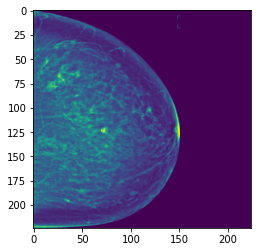

In [11]:
plt.imshow(next(iter(all_loader))[0][0][0][0])

/home/akis-linardos/BFP/src/data_loader.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return arr[[slice(*s) for s in slices]]


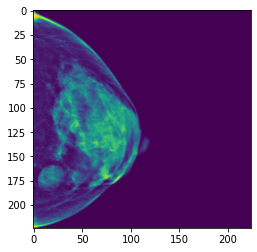

In [5]:
plt.imshow(next(iter(jarv_loader))[0][0][0])

In [6]:
next(iter(jarv_loader))[0][0][0]

tensor([[  0.,   0.,   0.,  ...,   0.,   7.,  48.],
        [  0.,   0.,   0.,  ...,  15.,  84., 176.],
        [  0.,   0.,   0.,  ..., 121., 197., 225.],
        ...,
        [  0.,   0.,   0.,  ..., 207., 213., 214.],
        [  0.,   0.,   0.,  ..., 235., 241., 244.],
        [  0.,   0.,   0.,  ..., 127., 160., 187.]])

In [7]:
next(iter(jarv_loader))[0][0][0]

tensor([[  0.,   0.,   0.,  ...,   0.,   7.,  48.],
        [  0.,   0.,   0.,  ...,  15.,  84., 176.],
        [  0.,   0.,   0.,  ..., 121., 197., 225.],
        ...,
        [  0.,   0.,   0.,  ..., 207., 213., 214.],
        [  0.,   0.,   0.,  ..., 235., 241., 244.],
        [  0.,   0.,   0.,  ..., 127., 160., 187.]])

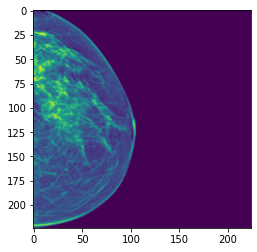

In [8]:
plt.imshow(next(iter(stge_loader))[0][0][0])
# next(iter(stge_loader))[0]

In [9]:
next(iter(stge_loader))[0][0][0]

tensor([[ 17.,  15.,  15.,  ...,   0.,   0.,   0.],
        [ 23.,  25.,  26.,  ...,   0.,   0.,   0.],
        [ 34.,  36.,  35.,  ...,   0.,   0.,   0.],
        ...,
        [194., 187., 181.,  ...,   0.,   0.,   0.],
        [131., 128., 125.,  ...,   0.,   0.,   0.],
        [ 71.,  67.,  63.,  ...,   0.,   0.,   0.]])

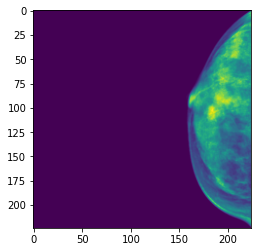

In [10]:
plt.imshow(next(iter(cmmd_loader))[0][0][0])

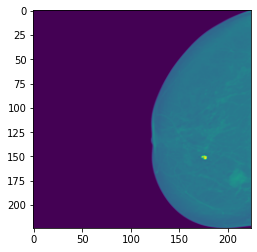

In [11]:
plt.imshow(next(iter(inbreast_loader))[0][0][0])

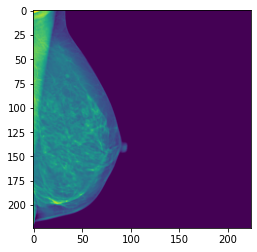

In [12]:
plt.imshow(next(iter(bcdr_loader))[0][0][0])